In [1]:

from utils.load import load_data, load_submission
from utils.feature import (
    add_hours,
    add_hours_trig_cyclic,
    apply_feature_engineering,
    get_dummies,
    fill_na_zero,
    drop_non_input_cols,
    normalize,
    standardize
)
from utils.model import ModelEvalWrapper

In [2]:
train_df, predict_df = load_data('../data')

In [3]:
_train_df, _predict_df = apply_feature_engineering(
    train_df,
    predict_df,
    funcs=[
        add_hours,
        fill_na_zero("all"),
        normalize(["txpower_cell0", "txpower_cell1", "txpower_cell2", "txpower_cell3"]),
        standardize(
            [
                "bandwidth_cell0",
                "antennas_cell0",
                "bandwidth_cell1",
                "antennas_cell1",
                "bandwidth_cell2",
                "antennas_cell2",
                "bandwidth_cell3",
                "antennas_cell3",
            ]
        ),
        get_dummies(
            [
                "hour",
                "rutype",
                "mode",
                "frequency_cell0",
                "frequency_cell1",
                "frequency_cell2",
                "frequency_cell3",
            ]
        ),
        drop_non_input_cols,
    ],
)


In [4]:
import pandas as pd
from sklearn.decomposition import PCA

y_train = _train_df['energy']
y_val = _predict_df['energy']
train_loads = _train_df[['load_cell0', 'load_cell1', 'load_cell2', 'load_cell3']]
val_loads = _predict_df[['load_cell0', 'load_cell1', 'load_cell2', 'load_cell3']]

pca = PCA(n_components=4)
_train_df_pca = pca.fit_transform(_train_df.drop('energy', axis=1))
_predict_df_pca = pca.transform(_predict_df.drop('energy', axis=1))

_train_df_pca = pd.DataFrame(_train_df_pca, columns=[f'PC{i+1}' for i in range(_train_df_pca.shape[1])])
_predict_df_pca = pd.DataFrame(_predict_df_pca, columns=[f'PC{i+1}' for i in range(_predict_df_pca.shape[1])])

_train_df_pca['energy'] = y_train
_predict_df_pca['energy'] = y_val
_train_df_pca[['load_cell0', 'load_cell1', 'load_cell2', 'load_cell3']] = train_loads
_predict_df_pca[['load_cell0', 'load_cell1', 'load_cell2', 'load_cell3']] = val_loads

In [5]:
from sklearn.svm import LinearSVR

model_getter = lambda: LinearSVR(max_iter=10000)
model_trainer = lambda model, X, y, *args, **kwargs: model.fit(
    X.drop(columns=["load_cell0", "load_cell1", "load_cell2", "load_cell3"]), y
)
model_predictor = lambda model, X: model.predict(
    X.drop(columns=["load_cell0", "load_cell1", "load_cell2", "load_cell3"])
)
model_eval = ModelEvalWrapper(
    model_getter,
    name="SVM with PCA input features",
    model_trainer=model_trainer,
    model_predictor=model_predictor,
)

model_eval.train_and_eval(_train_df_pca)

INFO:root:Fold 1/5
INFO:root:Train MAE: 7.4552, MAPE: 0.3204, MSE: 102.8265
INFO:root:Test MAE: 7.4640, MAPE: 0.3234, MSE: 102.2705
INFO:root:Fold 2/5
INFO:root:Train MAE: 7.4537, MAPE: 0.3202, MSE: 102.5044
INFO:root:Test MAE: 7.4652, MAPE: 0.3207, MSE: 103.6107
INFO:root:Fold 3/5
INFO:root:Train MAE: 7.4607, MAPE: 0.3203, MSE: 102.9120
INFO:root:Test MAE: 7.4410, MAPE: 0.3180, MSE: 102.1677
INFO:root:Fold 4/5
INFO:root:Train MAE: 7.4664, MAPE: 0.3210, MSE: 102.7232
INFO:root:Test MAE: 7.4181, MAPE: 0.3151, MSE: 103.0068
INFO:root:Fold 5/5
INFO:root:Train MAE: 7.4454, MAPE: 0.3193, MSE: 102.7293
INFO:root:Test MAE: 7.4984, MAPE: 0.3243, MSE: 102.7438
INFO:root:
Best model from fold 4
INFO:root:Best model mae: 7.4181, mape: 0.3151 mse: 103.0068

INFO:root:Average mae: 7.4574, mape: 0.3203, mse: 102.7599
INFO:root:Std mae: 0.0268, mape: 0.0034, mse: 0.5245

INFO:root:Analytic evaluations for best model
INFO:root:Error metrics by number of cells in usage
INFO:root:Metrics for 0 cells in 

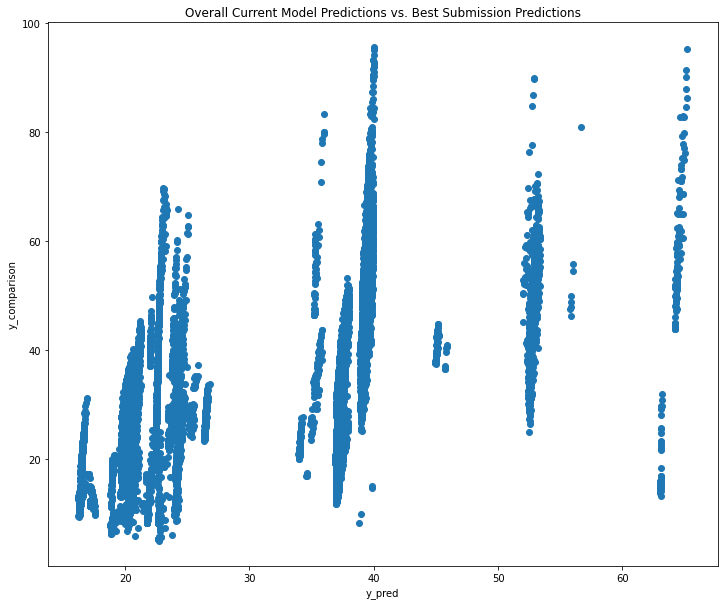

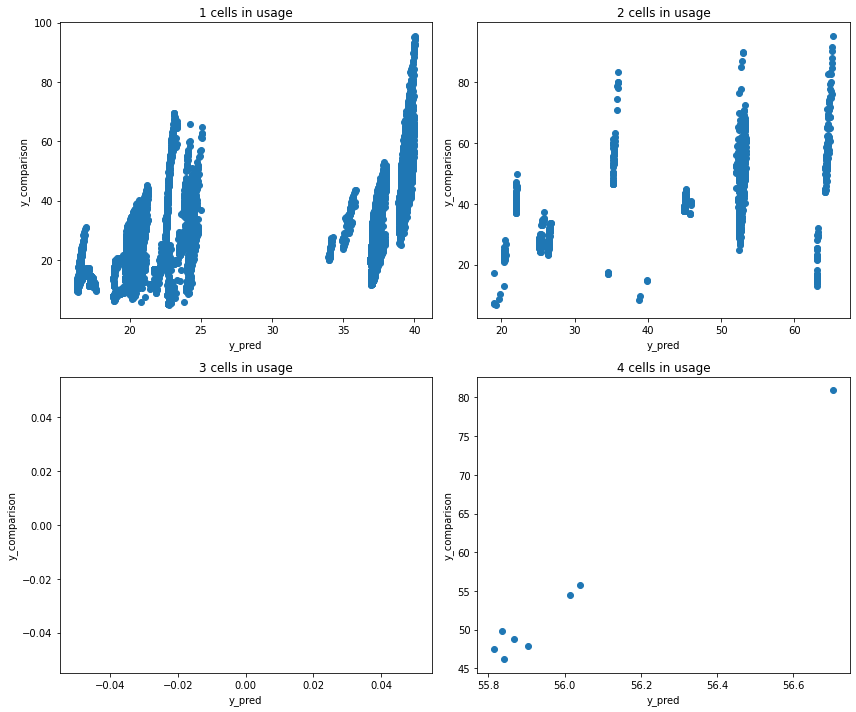

In [7]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 10)
best_submission = load_submission("bestsubmission.csv")
model_eval.compare_predictions_with(_predict_df_pca, best_submission['Energy'])